#  This cell import related Libraries

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 26.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
!pip install nervaluate

In [3]:
import pandas as pd
from collections import Counter
import sys
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import XLMRobertaForTokenClassification, XLMRobertaTokenizer
from datasets import load_dataset
import tqdm
tqdmn = tqdm.notebook.tqdm
from datasets import load_dataset
import os
from transformers import get_scheduler
from datasets import Dataset
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import copy
from nervaluate import Evaluator

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
def read_format(file_path):
    sentences = []
    ner_tags = []

    with open(file_path, 'r', encoding='utf-8') as file:
        current_sentence = []
        current_tags = []
        for line in file:
            line = line.strip()
            if line.startswith("Img_ID"):
                if current_sentence:
                    sentences.append(current_sentence)
                    ner_tags.append(current_tags)
                    current_sentence = []
                    current_tags = []
            else:
                tokens = line.split("\t")
                if len(tokens) == 2:
                    current_sentence.append(tokens[0])
                    current_tags.append(tokens[1])
                else:
                    print(f"Warning: Invalid line format in {file_path}: {line}")

        # Append the last sentence and its tags
        if current_sentence:
            sentences.append(current_sentence)
            ner_tags.append(current_tags)

    return sentences, ner_tags

file_path = '/content/drive/MyDrive/un_data/train.txt'  # Update with your file path
sentences, ner_tags = read_format(file_path)

for sentence, tags in zip(sentences, ner_tags):
    print("Sentence:", sentence)
    print("NER Tags:", tags)


Streaming output truncated to the last 5000 lines.
Sentence: ['FY25', 'में', 'PNB', 'जुटाएगा', '₹10000', 'करोड़,', 'इस', 'तरीके', 'की', 'ली', 'जाएगी', 'मदद']
NER Tags: ['B-TIMEX', 'O', 'B-NUMEX', 'O', 'B-NUMEX', 'I-NUMEX', 'O', 'O', 'O', 'O', 'O', 'O']
Sentence: ['IIFL', 'Finance', 'और', 'JM', 'Financial', 'Products', 'का', 'स्पेशल', 'ऑडिट,', 'RBI', '12', 'अप्रैल', 'से', 'करेगा', 'शुरू']
NER Tags: ['B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'B-TIMEX', 'I-TIMEX', 'O', 'O']
Sentence: ['Tata', 'Sons', 'ने', 'ब्लॉक', 'डील', 'में', 'TCS', 'के', '2.34', 'करोड़', 'शेयर', 'बेचने', 'की', 'पुष्टि', 'की,', 'पढ़ें', 'डिटेल']
NER Tags: ['B-ORGANIZATION', 'I-ORGANIZATION', 'O', 'B-MISC', 'I-LOCATION', 'O', 'B-ORGANIZATION', 'O', 'B-NUMEX', 'I-NUMEX', 'I-NUMEX', 'I-NUMEX', 'I-NUMEX', 'O', 'O', 'O', 'O']
Sentence: ['Banking', 'Central', ':', '90', 'साल', 'का', 'हुआ', 'RBI,भारत', 'को', 'संकटों', 'से', 'बचाने', 'के

In [27]:
labels_list = ["O", "B-FESTIVAL", "B-GAME", "B-LANGUAGE", "B-LITERATURE", "B-LOCATION", "B-MISC", "B-NUMEX", "B-ORGANIZATION", "B-PERSON", "B-RELIGION", "B-TIMEX", "I-FESTIVAL", "I-GAME", "I-LANGUAGE", "I-LITERATURE", "I-LOCATION", "I-MISC", "I-NUMEX", "I-ORGANIZATION", "I-PERSON", "I-RELIGION", "I-TIMEX","B-X"]
labels_list_1 = ["O", "FESTIVAL", "GAME", "LANGUAGE", "LITERATURE", "LOCATION", "MISC", "NUMEX", "ORGANIZATION", "PERSON", "RELIGION", "TIMEX"]

label2id = {}
id2label ={}
for i in range(len(labels_list)):
    label2id[labels_list[i]] = i
    id2label[i] = labels_list[i]


In [28]:
def convert_labels2id_list(list1):
  converted = [label2id[tag] for tag in list1 ]
  return converted

In [29]:
ner_tags = [convert_labels2id_list(list1) for list1 in ner_tags]
ner_tags[:5]

[[0, 0, 0, 0, 7, 18, 18, 18, 0, 16, 0, 0, 0, 0, 8, 19, 0, 0],
 [11, 8, 0, 0, 0, 7, 0, 18, 0, 8, 0, 6, 19, 0, 0, 6, 0],
 [8, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 18, 22],
 [11, 18, 18, 0, 9, 18, 0, 9, 20, 20, 20, 0, 8, 19, 0, 0],
 [0, 0, 8, 0, 0, 0, 0]]

In [30]:
c=0
for sentence, tags in zip(sentences, ner_tags):
    c+=1
    if c==20:
      break
    print("Sentence:", sentence)
    print("NER Tags:", tags)

Sentence: ['ये', 'कैसा', 'न्याय!', 'सामूहिक', 'दुष्कर्म', 'पीड़ित', 'छात्रा', 'का', 'स्कूल', 'से', 'काटा', 'नाम,', 'बोर्ड', 'एग्जाम', 'भी', 'नहीं', 'देने', 'दिया']
NER Tags: [0, 0, 0, 0, 7, 18, 18, 18, 0, 16, 0, 0, 0, 0, 8, 19, 0, 0]
Sentence: ['आज', 'बीजेपी', 'ला', 'सकती', 'है', 'अपना', 'संकल्प', 'पत्र,', 'कांग्रेस', 'के', 'न्याय', 'पत्र', 'का', "'GYAN'", 'से', 'देगी', 'जवाब']
NER Tags: [11, 8, 0, 0, 0, 7, 0, 18, 0, 8, 0, 6, 19, 0, 0, 6, 0]
Sentence: ['लोकसभा', 'चुनाव', 'के', 'लिए', 'कांग्रेस', 'ने', 'जारी', 'किया', 'अपना', 'घोषणा', 'पत्र,', 'जानें', 'क्या', 'है', '5', 'न्याय,', '25', 'गारंटी']
NER Tags: [8, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 18, 22]
Sentence: ['2024', 'की', 'जंग:', 'मोदी', 'की', 'गारंटी', 'V/S', 'राहुल', 'का', 'सामाजिक', 'न्याय,', 'जानिए', 'कौन', 'किस', 'पर', 'भारी']
NER Tags: [11, 18, 18, 0, 9, 18, 0, 9, 20, 20, 20, 0, 8, 19, 0, 0]
Sentence: ['ये', 'हैं', 'कांग्रेस', 'के', 'घोषणापत्र', 'के', 'वादे']
NER Tags: [0, 0, 8, 0, 0, 0, 0]
Sentence: ['ओल्ड', 'पेंशन

In [32]:
label2id

{'O': 0,
 'B-FESTIVAL': 1,
 'B-GAME': 2,
 'B-LANGUAGE': 3,
 'B-LITERATURE': 4,
 'B-LOCATION': 5,
 'B-MISC': 6,
 'B-NUMEX': 7,
 'B-ORGANIZATION': 8,
 'B-PERSON': 9,
 'B-RELIGION': 10,
 'B-TIMEX': 11,
 'I-FESTIVAL': 12,
 'I-GAME': 13,
 'I-LANGUAGE': 14,
 'I-LITERATURE': 15,
 'I-LOCATION': 16,
 'I-MISC': 17,
 'I-NUMEX': 18,
 'I-ORGANIZATION': 19,
 'I-PERSON': 20,
 'I-RELIGION': 21,
 'I-TIMEX': 22,
 'B-X': 23}

In [33]:
from sklearn.model_selection import train_test_split

def split_data(sentences, ner_tags, test_size=0.2, random_state=None):
    # Split the data into train and validation sets
    train_sentences, valid_sentences, train_ner_tags, valid_ner_tags = train_test_split(
        sentences, ner_tags, test_size=test_size, random_state=random_state)

    return train_sentences, valid_sentences, train_ner_tags, valid_ner_tags

# Example usage:
# sentences = [...]  # Your list of sentences
# ner_tags = [...]   # Your list of NER tags

train_sentences, valid_sentences, train_ner_tags, valid_ner_tags = split_data(sentences, ner_tags, test_size=0.2, random_state=42)

test_path = '/content/drive/MyDrive/un_data/test.txt'
test_sentences, test_ner_tags = read_format(test_path)
test_ner_tags = [convert_labels2id_list(list1) for list1 in test_ner_tags]
test_ner_tags[:5]
# Print the sentences and corresponding NER tags
for sentence, tags in zip(test_sentences, test_ner_tags):
    print("Sentence:", sentence)
    print("NER Tags:", tags)

print("Number of training sentences:", len(train_sentences))
print("Number of validation sentences:", len(valid_sentences))

Sentence: ['मार्कशीट', 'के', 'लिए', 'नर्सिंग', 'छात्राओं', 'ने', 'किया', 'प्रदर्शन']
NER Tags: [7, 0, 0, 0, 18, 0, 0, 0]
Sentence: ['इंतजार', 'खत्म,', 'जल्द', 'आएगा', 'बिहार', 'बोर्ड', '12वीं', 'का', 'रिजल्ट']
NER Tags: [0, 0, 0, 0, 0, 8, 19, 7, 0]
Sentence: ['लोकसभा', 'चुनाव', 'की', 'वजह', 'से', 'स्थगित', 'हुई', 'UPSC', 'की', 'प्रीलिम्स', 'परीक्षा,', 'जानें', 'कब', 'होगा', 'यह', 'एग्जाम']
NER Tags: [8, 18, 0, 0, 0, 0, 0, 8, 0, 11, 18, 0, 0, 0, 0, 0]
Sentence: ['जेईई', 'मेन', 'सत्र', '2', 'की', 'सिटी', 'स्लिप', 'जारी,', 'इस', 'डायरेक्ट', 'लिंक', 'से', 'ऐसे', 'करें', 'डाउनलोड']
NER Tags: [8, 16, 13, 7, 0, 6, 14, 0, 0, 0, 0, 0, 0, 0, 0]
Sentence: ['बिहार', 'बोर्ड', 'के', '12वीं', 'के', 'नतीजे', 'घोषित,', 'फटाफट', 'ऐसे', 'करें', 'चेक']
NER Tags: [8, 19, 18, 7, 18, 0, 0, 0, 0, 0, 0]
Sentence: ['इस', 'दिन', 'आएंगे', '10वीं', 'के', 'नतीजे,', 'टॉपर', 'वेरिफिकेशन', 'प्रोसेस', 'जल्द', 'होगा', 'शुरू']
NER Tags: [11, 22, 0, 7, 18, 0, 0, 8, 2, 19, 0, 0]
Sentence: ['CUET-UG', 'के', 'लिए', 'आवेदन', 

In [34]:
print(len(train_ner_tags))

4356


In [35]:

train_pdf = pd.DataFrame({"sentences":train_sentences,"labels":train_ner_tags,"id":0})
dev_pdf = pd.DataFrame({"sentences":valid_sentences,"labels":valid_ner_tags,"id":0})
test_pdf =pd.DataFrame({"sentences":test_sentences,"labels":test_ner_tags,"id":0})




################################################

In [36]:
train_pdf

,sentences,labels,id
0,"[विकास, को, रफ्तार, देंगे, मुख्यमंत्री, नायब, ...","[0, 0, 0, 0, 0, 9, 20, 0, 9, 20]",0
1,"[MVA, की, बैठक, में, दूर, होगी, खटास,, सीट, बं...","[8, 0, 0, 0, 0, 0, 0, 0, 0, 18, 0, 0, 0, 0]",0
2,"[लॉरेंस, गैंग, में, कौन, है, चीकू,, जिसकी, छात...","[9, 16, 0, 0, 0, 0, 0, 0, 5, 0, 7, 0, 0, 0, 7,...",0
3,"[TMC, का, दावा,, आयकर, अधिकारियों, ने, अभिषेक,...","[8, 0, 0, 0, 0, 18, 0, 9, 20, 0, 7, 0, 0]",0
4,"[मिथुन, राशि, वालों, की, सुख-सुविधाओं, में, हो...","[7, 18, 18, 0, 0, 18, 0, 0, 0, 0, 0, 0, 7]",0
...,...,...,...
4351,"[ईशान-श्रेयस, विवाद, में, इस, पाकिस्तानी, की, ...","[9, 16, 9, 19, 0, 7, 6, 0, 0, 0, 8, 0, 0, 0]",0
4352,"[संजय, सिंह, को, जमानत, पर, अब, दो, और, AAP, न...","[9, 20, 0, 0, 0, 11, 7, 18, 8, 18, 9, 0, 16, 0...",0
4353,"[चुनाव, से, पहले, सपा, में, संग्राम..., रामपुर...","[0, 0, 7, 8, 0, 0, 0, 0, 7, 5, 18, 5, 18, 9]",0
4354,"[बीजेपी, ने, डिब्रूगढ़, सीट, पर, केंद्रीय, मंत...","[8, 0, 5, 18, 0, 0, 18, 0, 0, 0, 9, 20, 0, 0, 0]",0


In [37]:
dev_pdf

,sentences,labels,id
0,"[लोकसभा, चुनाव:, बिहार, में, बाहुबली, करेंगे, ...","[8, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 8, 18, 19, 1...",0
1,"[डबचिक, टूरिस्ट, कॉम्पलेक्स, कभी, था, गुलज़ार,,...","[8, 19, 16, 11, 0, 0, 0, 7, 0]",0
2,"[जूलरी,, कैश,, प्रॉपर्टी..., जिन, वरुण, गांधी,...","[5, 0, 5, 0, 6, 0, 0, 0, 7, 9, 20, 0, 8, 0]",0
3,"[बौना, तो, फिर, बौना, होता, है, और, देवता..., ...","[5, 0, 0, 5, 0, 0, 0, 7, 0, 0, 7, 9, 20, 7, 9,...",0
4,"[एडीसी, ने, भिवानी, में, निर्माण, कार्यों, का,...","[8, 0, 5, 0, 0, 0, 0, 0, 0]",0
...,...,...,...
1085,"[ब्रह्म, ही, तो, है, अन्न]","[9, 0, 0, 0, 0]",0
1086,"[वरुण, गांधी, को, बीजेपी, के, टिकट, को, लेकर, ...","[9, 20, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0
1087,"['कांग्रेस, के, मेनिफेस्टो, में, बंटवारे, की, ...","[5, 8, 18, 3, 0, 0, 0, 7, 10, 19, 0, 0, 0, 0, ...",0
1088,"[Gold, price:, शिखर, पर, सोना,, MCX, पर, 69465...","[6, 14, 0, 5, 0, 0, 0, 8, 0, 7, 18, 0, 0, 11, ...",0


In [38]:
test_pdf

,sentences,labels,id
0,"[मार्कशीट, के, लिए, नर्सिंग, छात्राओं, ने, किय...","[7, 0, 0, 0, 18, 0, 0, 0]",0
1,"[इंतजार, खत्म,, जल्द, आएगा, बिहार, बोर्ड, 12वी...","[0, 0, 0, 0, 0, 8, 19, 7, 0]",0
2,"[लोकसभा, चुनाव, की, वजह, से, स्थगित, हुई, UPSC...","[8, 18, 0, 0, 0, 0, 0, 8, 0, 11, 18, 0, 0, 0, ...",0
3,"[जेईई, मेन, सत्र, 2, की, सिटी, स्लिप, जारी,, इ...","[8, 16, 13, 7, 0, 6, 14, 0, 0, 0, 0, 0, 0, 0, 0]",0
4,"[बिहार, बोर्ड, के, 12वीं, के, नतीजे, घोषित,, फ...","[8, 19, 18, 7, 18, 0, 0, 0, 0, 0, 0]",0
...,...,...,...
987,"[सिर्फ, सियासत, के, माहिर, नहीं,, रुपये-पैसे, ...","[0, 8, 0, 0, 0, 0, 7, 18, 18, 0, 0, 0, 0, 9, 0...",0
988,"[करियर, की, पहली, गेंद, पर, 6,, राशिद, खान, के...","[0, 0, 7, 18, 0, 7, 18, 9, 20, 0, 0, 0, 0, 0, ...",0
989,"[ओपनिंग, मैच, से, ठीक, पहले, सीएसके, को, लगा, ...","[7, 18, 0, 0, 7, 9, 0, 0, 0, 0, 0, 7, 0, 0, 0,...",0
990,"[इंटरनेशनल, मैच, में, एक, के, बाद, एक, 3, खिला...","[2, 13, 0, 7, 18, 22, 7, 18, 18, 6, 0, 7, 18, ...",0


# Select and load tokenizer and model

# "Course grained checkpoints"



In [40]:
#run this cell only for training
#set Hyperparameter
# Set Hyperparameters

num_labels =24
model_max_length = 92
lr=5e-05
n_epochs = 10
batch_size= 16
min_batch_size=8
batch_size_c = batch_size / min_batch_size
early_stoping_patience = 3 # if valid loss will increase 3 consecutive times with a margin then training will stop.
tokenizer_path = "FacebookAI/xlm-roberta-large"
initial_model = "FacebookAI/xlm-roberta-large"#FacebookAI/xlm-roberta-large

In [41]:
#load tokenizer and model

tokenizer = XLMRobertaTokenizer.from_pretrained(tokenizer_path)
tokenizer.model_max_length = model_max_length
print(tokenizer.model_max_length )

# initialize the model and provide the 'num_labels' used to create the classification layer
model = XLMRobertaForTokenClassification.from_pretrained(initial_model,num_labels=num_labels)    #, num_labels=num_labels)
# assign the 'id2label' and 'label2id' model configs
model.config.id2label = id2label
model.config.label2id = label2id
print("model loded")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

92


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model loded


# Prepare data for model
#  If a tokanized sentence length is > 92 then we will cut the tokanized #sentence at 92 ( max length = 92)
# Word id created
# Labels allignment (expandation) according to tokanized sentences.

In [42]:
#prepare data for model
#If a tokanized sentence length is > 92 then we will cut the tokanized sentenc at 92 ( max length = 92)
word_ids_of_sentences = []




def add_encodings(example):
    global word_ids_of_sentences
    #print(example)


    # For allign_labels with tokenized sentence

    word_id_value=0
    word_ids_for_curr_sentence = []


    for word in example['sentences']:
        #print(word)

        tokenized_word = tokenizer.convert_ids_to_tokens(tokenizer(word,is_split_into_words=False)["input_ids"],skip_special_tokens=False)[1:-1]
        # print(tokenized_word)
        if(len(tokenized_word) == 0):
            print(example)
            print(tokenized_word)
            sss

        word_ids_for_curr_sentence += ([word_id_value]*len(tokenized_word))
        if len(word_ids_for_curr_sentence)>=90:
            word_ids_for_curr_sentence = word_ids_for_curr_sentence[:90]
            break

        word_id_value+=1


    word_ids_of_sentences.append(word_ids_for_curr_sentence)
    #for printing special tokens
    #print(tokenizer.convert_ids_to_tokens(tokenizer("sumit",is_split_into_words=False)["input_ids"],skip_special_tokens=False))


    encodings = tokenizer(example['sentences'], truncation=True, padding='max_length', is_split_into_words=True)



    if sum(encodings["attention_mask"]) != len(word_ids_for_curr_sentence)+2:
        if (len(word_ids_for_curr_sentence)+2) <=90:

            print(len(word_ids_for_curr_sentence),sum(encodings["attention_mask"]))
            print( tokenizer.convert_ids_to_tokens(tokenizer(example['sentences'], truncation=True, is_split_into_words=True)["input_ids"],skip_special_tokens=False)[1:-1])
            print(word_ids_for_curr_sentence)
            sss

    ex_lab=example['labels']

    extended_labels=[]

    for  w_id in word_ids_for_curr_sentence:
        extended_labels.append(ex_lab[w_id])
    extended_labels.insert(0,0)         #for special token generated by tokenizer
    extended_labels.append(0)           #for special token generated by tokenizer
    labels_ = extended_labels+ [0] * (tokenizer.model_max_length - len(extended_labels))  #padding
    if (len(labels_)>92):
        labels_=labels_[:92]

    # return the encodings and the extended ner_tags
    #rint("complete")
    return { **encodings, 'labels': labels_ }

In [43]:
valid_dataset = Dataset.from_pandas(dev_pdf.iloc[:5])
#valid_dataset=valid_dataset.map(add_encodings)

In [44]:
valid_dataset[:3]

{'sentences': [['लोकसभा',
   'चुनाव:',
   'बिहार',
   'में',
   'बाहुबली',
   'करेंगे',
   "'खेला'?",
   'I.N.D.I.A.',
   'गठबंधन',
   'और',
   'NDA',
   'ने',
   'खोल',
   'दिए',
   'अपने',
   'द्वार'],
  ['डबचिक',
   'टूरिस्ट',
   'कॉम्पलेक्स',
   'कभी',
   'था',
   'गुलज़ार,',
   'अब',
   'छायी',
   'वीरानी'],
  ['जूलरी,',
   'कैश,',
   'प्रॉपर्टी...',
   'जिन',
   'वरुण',
   'गांधी',
   'का',
   'बीजेपी',
   'ने',
   'काटा',
   'टिकट',
   'उनकी',
   'नेटवर्थ',
   'कितनी?']],
 'labels': [[8, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 8, 18, 19, 18, 19],
  [8, 19, 16, 11, 0, 0, 0, 7, 0],
  [5, 0, 5, 0, 6, 0, 0, 0, 7, 9, 20, 0, 8, 0]],
 'id': [0, 0, 0]}

In [45]:
valid_data = valid_dataset.map(add_encodings)

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

In [46]:

train_dataset =  Dataset.from_pandas(train_pdf)
train_labels = train_dataset['labels']
valid_dataset = Dataset.from_pandas(dev_pdf)




valid_labels = valid_dataset['labels']
valid_true_flat_labels = [item for sublist in valid_labels for item in sublist]



word_ids_of_test_sentences = []




print("encodinmmg start")
train_dataset = train_dataset.map(add_encodings)
word_ids_of_train_sentences = word_ids_of_sentences
word_ids_of_sentences=[]

valid_dataset=valid_dataset.map(add_encodings)
word_ids_of_valid_sentences=word_ids_of_sentences
word_ids_of_sentences=[]




print("encodinmmg complete")





train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
valid_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

train_data = torch.utils.data.DataLoader(train_dataset, batch_size=min_batch_size)
valid_data = torch.utils.data.DataLoader(valid_dataset, batch_size=min_batch_size)


encodinmmg start


Map:   0%|          | 0/4356 [00:00<?, ? examples/s]

Map:   0%|          | 0/1090 [00:00<?, ? examples/s]

encodinmmg complete


In [47]:
# Number of batches for each data
print(len(train_data))
print(train_data)
print(len(valid_data))
print(valid_data)


545
137


# For testing only run next cell

In [48]:
test_dataset =  Dataset.from_pandas(test_pdf)
test_labels = test_dataset['labels']
test_true_flat_labels = [item for sublist in test_labels for item in sublist]



# bn_test_dataset = Dataset.from_pandas(bn_test_pdf)
# bn_test_labels = bn_test_dataset['labels']
# bn_test_true_flat_labels = [item for sublist in bn_test_labels for item in sublist]



word_ids_of_sentences=[]





print("encodinmmg start")
test_dataset = test_dataset.map(add_encodings)
word_ids_of_test_sentences = word_ids_of_sentences
word_ids_of_sentences=[]

print("encodinmmg complete")





test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

test_data = torch.utils.data.DataLoader(test_dataset, batch_size=min_batch_size)
len(test_data)




encodinmmg start


Map:   0%|          | 0/992 [00:00<?, ? examples/s]

encodinmmg complete


124

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Run next 4 cells only for training or skip

In [50]:
#run this cell only for training

num_training_steps = n_epochs * len(train_data)#/batch_size

optimizer = optim.AdamW(params=model.parameters(), lr=lr)
lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=5, num_training_steps=num_training_steps)

print("training start")


previous_total_valid_loss = sys.float_info.max
valid_min_loss = previous_total_valid_loss
early_stoping_flag=0
train_loss_epoch=[]
valid_loss_epoch=[]
directory = "./x_"+str(lr)+"_"+str(batch_size)+"_"+str(n_epochs)+"_/"
# iterate through the data 'n_epochs' times
for epoch in tqdmn(range(n_epochs)):
    # set the model in 'train' mode and send it to the device
    model.train().to(device)
    print(epoch)
    print(directory)


    train_loss = []
    current_loss = 0
    total_loss=0
    # iterate through each batch of t    he train data
    for i, batch in enumerate(tqdmn(train_data)):

        # move the batch tensors to the same device as the
        batch = { k: v.to(device) for k, v in batch.items() }
        # send 'input_ids', 'attention_mask' and 'labels' to the model
        # print(len(batch["labels"][0]))
        # print(len(batch["input_ids"][0]))
        # print(batch)

        outputs = model(**batch)
        # the outputs are of shape (loss, logits)
        #print(outputs[1])


        loss = outputs[0]
        #print("loss",loss)
        loss.backward()


        current_loss += loss.item()

        if i % 4 == 0 and i > 0: #if i >= 0:  # #           #if i % 8 == 0 and i > 0:
            # update the model using the optimizer
            optimizer.step()
            lr_scheduler.step()
            # once we update the model we set the gradients to zero
            optimizer.zero_grad()
            # store the loss value for visualization
            train_loss.append(current_loss/batch_size)
            total_loss=total_loss + current_loss/batch_size
            current_loss = 0
    train_loss_epoch.append(total_loss)
    # update the model one last time for this epoch
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    model.save_pretrained(directory+"best_e_"+str(epoch))

    print(directory + ' files saved')
    print('total_loss',total_loss)

    #validation

    model.eval().to(device)
    valid_loss = []
    valid_current_loss = 0
    valid_total_loss=0

    # iterate through each batch of t    he train data
    for i, batch in enumerate(tqdmn(valid_data)):

        # move the batch tensors to the same device as the
        batch = { k: v.to(device) for k, v in batch.items() }
        # send 'input_ids', 'attention_mask' and 'labels' to the model
        outputs = model(**batch)
        # the outputs are of shape (loss, logits)
        #print(outputs[1])


        loss = outputs[0]
        #print("loss",loss)


        valid_current_loss += loss.item()
        #print(valid_current_loss)

        if i % batch_size_c == 0 and i > 0: #depend on batch size and GPU

            valid_loss.append(valid_current_loss/batch_size)
            valid_total_loss=valid_total_loss + valid_current_loss/batch_size
            valid_current_loss = 0
            #print("valid_total_loss ",valid_total_loss)

    print("valid_total_loss ",valid_total_loss)
    valid_loss_epoch.append(valid_total_loss)
    if valid_total_loss < valid_min_loss:
        valid_min_loss = valid_total_loss
        #model.save_pretrained(directory+"best_e_"+str(epoch))


    if previous_total_valid_loss < valid_total_loss:
        early_stoping_flag += 1
    else:
        early_stoping_flag=0
    previous_total_valid_loss = valid_total_loss


    if early_stoping_flag == early_stoping_patience:
        print("early_stoping occure")
        break



print('training complete')




training start


  0%|          | 0/10 [00:00<?, ?it/s]

0
./x_5e-05_16_10_/


  0%|          | 0/545 [00:00<?, ?it/s]

./x_5e-05_16_10_/ files saved
total_loss 16.172660562209785


  0%|          | 0/137 [00:00<?, ?it/s]

valid_total_loss  2.577569874934852
1
./x_5e-05_16_10_/


  0%|          | 0/545 [00:00<?, ?it/s]

./x_5e-05_16_10_/ files saved
total_loss 9.022544004954398


  0%|          | 0/137 [00:00<?, ?it/s]

valid_total_loss  1.9829513761214912
2
./x_5e-05_16_10_/


  0%|          | 0/545 [00:00<?, ?it/s]

./x_5e-05_16_10_/ files saved
total_loss 7.1762446677312255


  0%|          | 0/137 [00:00<?, ?it/s]

valid_total_loss  1.8171087186783552
3
./x_5e-05_16_10_/


  0%|          | 0/545 [00:00<?, ?it/s]

./x_5e-05_16_10_/ files saved
total_loss 5.889891566243023


  0%|          | 0/137 [00:00<?, ?it/s]

valid_total_loss  1.5738470302894711
4
./x_5e-05_16_10_/


  0%|          | 0/545 [00:00<?, ?it/s]

./x_5e-05_16_10_/ files saved
total_loss 5.061458176001906


  0%|          | 0/137 [00:00<?, ?it/s]

valid_total_loss  1.55725161684677
5
./x_5e-05_16_10_/


  0%|          | 0/545 [00:00<?, ?it/s]

./x_5e-05_16_10_/ files saved
total_loss 4.257948496146128


  0%|          | 0/137 [00:00<?, ?it/s]

valid_total_loss  1.5457367980852723
6
./x_5e-05_16_10_/


  0%|          | 0/545 [00:00<?, ?it/s]

./x_5e-05_16_10_/ files saved
total_loss 3.6536666818428785


  0%|          | 0/137 [00:00<?, ?it/s]

valid_total_loss  1.6842545946128666
7
./x_5e-05_16_10_/


  0%|          | 0/545 [00:00<?, ?it/s]

./x_5e-05_16_10_/ files saved
total_loss 3.1335817377548665


  0%|          | 0/137 [00:00<?, ?it/s]

valid_total_loss  1.662696730112657
8
./x_5e-05_16_10_/


  0%|          | 0/545 [00:00<?, ?it/s]

./x_5e-05_16_10_/ files saved
total_loss 2.7264968242961913


  0%|          | 0/137 [00:00<?, ?it/s]

valid_total_loss  1.756296182749793
9
./x_5e-05_16_10_/


  0%|          | 0/545 [00:00<?, ?it/s]

./x_5e-05_16_10_/ files saved
total_loss 2.3240614061942324


  0%|          | 0/137 [00:00<?, ?it/s]

valid_total_loss  1.7528414581902325
training complete


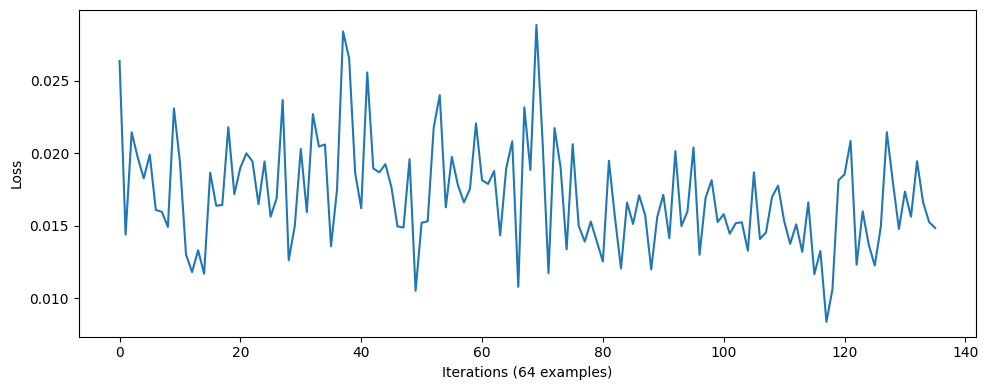

In [51]:
"""
Visualize the training loss through the iterations.
"""

fig, ax = plt.subplots(figsize=(10, 4))
# visualize the loss values
ax.plot(train_loss)
# set the labels
ax.set_ylabel('Loss')
ax.set_xlabel('Iterations (64 examples)')
fig.tight_layout()
plt.show()

[16.172660562209785, 9.022544004954398, 7.1762446677312255, 5.889891566243023, 5.061458176001906, 4.257948496146128, 3.6536666818428785, 3.1335817377548665, 2.7264968242961913, 2.3240614061942324]
[2.577569874934852, 1.9829513761214912, 1.8171087186783552, 1.5738470302894711, 1.55725161684677, 1.5457367980852723, 1.6842545946128666, 1.662696730112657, 1.756296182749793, 1.7528414581902325]


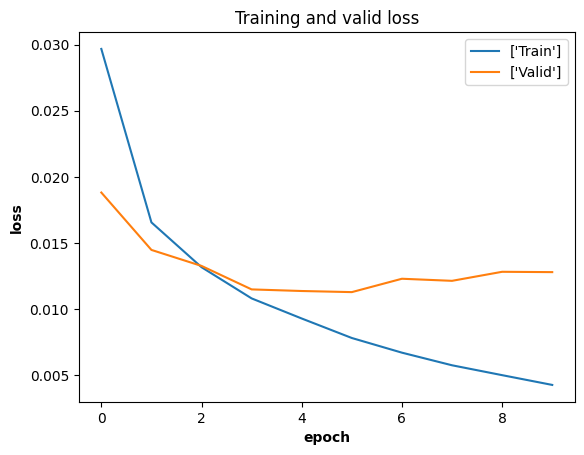

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [52]:
"""
Visualize the training and valid loss through the epochs.
"""
print(train_loss_epoch)
print(valid_loss_epoch)
#loss normalization (loss oer batch)
loss1=[i/len(train_data) for i in train_loss_epoch]
loss2=[i/len(valid_data) for i in valid_loss_epoch]
epoch=[i for i in range(len(loss1))]


plt.plot(epoch,loss1,label=['Train'])
plt.plot(epoch,loss2,label=['Valid'])
# plt.plot(loss2)

# Adding Title to the Plot
plt.title("Training and valid loss")

# Setting the X and Y labels
plt.xlabel('epoch',fontweight='bold')
plt.ylabel('loss',fontweight='bold')
plt.legend()

plt.show()
epoch

In [65]:
best_model_path

'/content/x_5e-05_16_10_/best_e_3'

# Prediction on M2

In [62]:
#best_model_path="/home/naive238/nlp/Sumit/multiconer2/ce/model/xlm_r_m2_fg_checkpoint_5e-06_64_10_epoch10_finetune_it/x_1e-06_64_20_/best_e_2"
#best_model_path="/home/naive238/nlp/Sumit/multiconer2/ce/model/xlm_r_m2_fg_checkpoint_1e-06_64_10_epoch10_finetune_hi/x_1e-06_64_15/best_e_14"
#best_model_path = "/home/naive238/nlp/Sumit/multiconer2/ce/model/xlm_r_m2_fg_checkpoint_5e-06_64_10_epoch10_finetune_de/x_1e-06_64_20_/best_e_19"
#best_model_path="/home/naive238/nlp/Sumit/multiconer2/ce/model/xlm_r_m2_fg_checkpoint_5e-06_64_10_epoch10_finetune_en/x_1e-06_64_20_/best_e_13"
#best_model_path"/home/naive238/nlp/Sumit/multiconer2/ce/model/xlm_r_m2_fg_checkpoint_5e-06_64_10_epoch10_finetune_it/x_1e-06_64_20_/best_e_2"
#best_model_path="/home/naive238/nlp/Sumit/multiconer2/ce/model/xlm_r_m2_fg_checkpoint_5e-06_64_10_epoch10_finetune_fr/x_1e-06_64_20_/best_e_4"
#best_model_path="/home/naive238/nlp/Sumit/multiconer2/ce/model/xlm_r_m2_fg_checkpoint_5e-06_64_10_epoch10_finetune_uk/x_1e-06_64_20_/best_e_15"
#best_model_path="/home/naive238/nlp/Sumit/multiconer2/ce/model/xlm_r_m2_fg_checkpoint_5e-06_64_10_epoch10_finetune_sv/x_1e-06_64_20_/best_e_19"

best_model_path="/content/x_5e-05_16_10_/best_e_3"
num_labels = 24
model_max_length = 92
batch_size= 16
min_batch_size=8
batch_size_c = batch_size / min_batch_size



In [56]:
# Prediction
def  prediction(best_model_path, eval_data):

    confusion = torch.zeros(num_labels, num_labels)
    predicted=[]
    tokanised_exam=[]
    true_labels=[]

    confusion = torch.zeros(num_labels, num_labels)
    predicted_for_classification_report=[]

    ##################################################
    #load best model


    print(best_model_path)

    model = XLMRobertaForTokenClassification.from_pretrained(best_model_path)



    model = model.eval().to(device)
    print("model device")
    # batch the train data so that each batch contains 4 examples (using 'batch_size')
    #test_data = torch.utils.data.DataLoader(test_dataset, batch_size=16)

    eval_data = eval_data



    # iterate through each batch of the eval data
    for i, batch in enumerate(tqdmn(eval_data)):



      # do not calculate the gradients
      with torch.no_grad():
          # move the batch tensors to the same device as the model
          batch = { k: v.to(device) for k, v in batch.items() }
          # send 'input_ids', 'attention_mask' and 'labels' to the model
          outputs = model(**batch)
          loss = outputs[0]
          #print("loss",loss)


      # get the sentence lengths
      s_lengths = batch['attention_mask'].sum(dim=1)
      # iterate through the examples
      for idx, length in enumerate(s_lengths):
          # get the true values
          true_values = batch['labels'][idx][:length]
          true_labels.extend(true_values.tolist())
          #print("true_values",len(true_values))
          # get the predicted values
          pred_values = torch.argmax(outputs[1], dim=2)[idx][:length]

          pred_values = pred_values.tolist()
          # pred_values = [val for val in pred_values]
          # if len(pred_values) != len(true_values):
          #   print("pred_values_____________________________",len(pred_values))
          predicted.append(pred_values)
          predicted_for_classification_report.extend(pred_values)

          # go through all true and predicted values and store them in the confusion matrix
          # for true, pred in zip(true_values, pred_values):
          #     confusion[true.item()][pred.item()] += 1
    return predicted, predicted_for_classification_report





In [63]:
valid_predicted, valid_predicted_for_classification_report= prediction(best_model_path, valid_data)

/content/x_5e-05_16_10_/best_e_3
model device


  0%|          | 0/137 [00:00<?, ?it/s]

In [64]:
test_predicted, valid_predicted_for_classification_report= prediction(best_model_path, test_data)

/content/x_5e-05_16_10_/best_e_3
model device


  0%|          | 0/124 [00:00<?, ?it/s]

In [66]:
def convert_id2label_list(list_of_id):
  converted=[]
  for i in list_of_id:
    converted.append(id2label[i])
  return converted

In [67]:
id2label

{0: 'O',
 1: 'B-FESTIVAL',
 2: 'B-GAME',
 3: 'B-LANGUAGE',
 4: 'B-LITERATURE',
 5: 'B-LOCATION',
 6: 'B-MISC',
 7: 'B-NUMEX',
 8: 'B-ORGANIZATION',
 9: 'B-PERSON',
 10: 'B-RELIGION',
 11: 'B-TIMEX',
 12: 'I-FESTIVAL',
 13: 'I-GAME',
 14: 'I-LANGUAGE',
 15: 'I-LITERATURE',
 16: 'I-LOCATION',
 17: 'I-MISC',
 18: 'I-NUMEX',
 19: 'I-ORGANIZATION',
 20: 'I-PERSON',
 21: 'I-RELIGION',
 22: 'I-TIMEX',
 23: 'B-X'}

# Post processing ( shrinking of expanded labels) and score calculation

In [68]:
#label post allignment
def generate_score(word_ids_of_sentences,predicted,shrink_labels,true_flat_labels):
#     print(word_ids_of_sentences[0])
#     print(len(shrink_labels[0]))
#     print(shrink_labels[0])

#     print(predicted[0])

    #all_tags = predicted

    shrink_predicted = []

    for i in range(len(word_ids_of_sentences)):
        #print(i)

        predicted[i] = predicted[i][1:-1]

        tags = []
        for j in range(len(word_ids_of_sentences[i])):

            if(j == 0 or word_ids_of_sentences[i][j] == word_ids_of_sentences[i][j-1]+1):
                tags.append(predicted[i][j])


        shrink_predicted.append(tags)

    #predicted_for_classification_report = [item for sublist in new_all_tags for item in sublist]
    if len(shrink_predicted) != len(shrink_labels):
        print("generated tags samples are not eqal number of sampales" )
    predicted_for_classification_report =[]
    allign_predicted_for_sentence=[]

    not_equal = 0
    for i in  range(len(shrink_labels)):
        if len(shrink_labels[i]) == len(shrink_predicted[i]):
            allign_predicted_for_sentence.append(shrink_predicted[i])
            predicted_for_classification_report = predicted_for_classification_report+shrink_predicted[i]

        elif len(shrink_labels[i]) > len(shrink_predicted[i]):
            not_equal+=1
            allign_predicted_for_sentence.append(shrink_predicted[i] +[0] * (len(shrink_labels[i]) - len(shrink_predicted[i])))
            predicted_for_classification_report = predicted_for_classification_report+shrink_predicted[i] +[0] * (len(shrink_labels[i]) - len(shrink_predicted[i]))

        else :
            not_equal+=1
            allign_predicted_for_sentence.append(shrink_predicted[i][:len(shrink_labels[i])])
            predicted_for_classification_report = predicted_for_classification_report+shrink_predicted[i][:len(shrink_labels[i])]


    if len(predicted_for_classification_report) != len(true_flat_labels):
        print("generated tags count are not equal number of count" )


    print("not_equal =", not_equal)



    ######## classification_report


    target_names = labels_list
    print(classification_report(true_flat_labels, predicted_for_classification_report, target_names=target_names,labels=[i for i in range(num_labels)]))

    target_names_1 =labels_list_1

    true_labels = [convert_id2label_list(id_list) for id_list in  shrink_labels]
    predicted_labels = [convert_id2label_list(id_list) for id_list in shrink_predicted]

    evaluator = Evaluator(true_labels,predicted_labels, tags=target_names_1, loader="list")

    results, results_by_tag = evaluator.evaluate()
    macro_f1=0
    for tag in results_by_tag.keys():
        print(tag +" F1 score = ", results_by_tag[tag]["strict"]["f1"])
        macro_f1=macro_f1 + results_by_tag[tag]["strict"]["f1"]
    print("Avrrage macro f1 score = ",macro_f1/6)
    #print(results)

    print("Strict f1 score = ",results["strict"]["f1"])
    return predicted_labels


In [69]:
len(labels_list_1)

12

# Score at augmented  valid data

In [70]:
valid_predicted_labels=generate_score( word_ids_of_valid_sentences,copy.deepcopy(valid_predicted),valid_labels,valid_true_flat_labels)

not_equal = 0
                precision    recall  f1-score   support

             O       0.85      0.95      0.90      9911
    B-FESTIVAL       0.00      0.00      0.00         2
        B-GAME       0.65      0.39      0.49        33
    B-LANGUAGE       0.00      0.00      0.00        24
  B-LITERATURE       0.00      0.00      0.00         6
    B-LOCATION       0.64      0.73      0.68       726
        B-MISC       0.47      0.25      0.33       260
       B-NUMEX       0.68      0.51      0.58       942
B-ORGANIZATION       0.80      0.65      0.72       836
      B-PERSON       0.72      0.73      0.73       624
    B-RELIGION       0.88      0.56      0.68        25
       B-TIMEX       0.73      0.51      0.60       383
    I-FESTIVAL       0.00      0.00      0.00         0
        I-GAME       0.77      0.17      0.28        59
    I-LANGUAGE       0.00      0.00      0.00        10
  I-LITERATURE       0.00      0.00      0.00        13
    I-LOCATION       0.51      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

O F1 score =  0
FESTIVAL F1 score =  0
GAME F1 score =  0.20689655172413796
LANGUAGE F1 score =  0
LITERATURE F1 score =  0
LOCATION F1 score =  0.6017897091722595
MISC F1 score =  0.2913907284768212
NUMEX F1 score =  0.4220183486238532
ORGANIZATION F1 score =  0.553381777529346
PERSON F1 score =  0.6604506604506605
RELIGION F1 score =  0.5384615384615384
TIMEX F1 score =  0.5137614678899082
Avrrage macro f1 score =  0.6313584637214208
Strict f1 score =  0.5161586064634426


# Score at assignment  valid data

# Prediction on test data. Ignore score ( all true value of labels of test data are set to 'O' for ease of implimentation.)

In [71]:
test_predicted_labels=generate_score( word_ids_of_test_sentences,copy.deepcopy(test_predicted),test_labels,test_true_flat_labels)

not_equal = 0
                precision    recall  f1-score   support

             O       0.85      0.95      0.90      8838
    B-FESTIVAL       0.00      0.00      0.00         0
        B-GAME       0.70      0.32      0.44        59
    B-LANGUAGE       0.00      0.00      0.00        36
  B-LITERATURE       0.00      0.00      0.00         9
    B-LOCATION       0.65      0.71      0.68       558
        B-MISC       0.42      0.22      0.29       214
       B-NUMEX       0.74      0.57      0.64       903
B-ORGANIZATION       0.79      0.67      0.72       734
      B-PERSON       0.70      0.73      0.71       583
    B-RELIGION       0.50      0.40      0.44         5
       B-TIMEX       0.78      0.48      0.59       299
    I-FESTIVAL       0.00      0.00      0.00         0
        I-GAME       0.62      0.08      0.14        65
    I-LANGUAGE       0.00      0.00      0.00        22
  I-LITERATURE       0.00      0.00      0.00        11
    I-LOCATION       0.50      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

O F1 score =  0
FESTIVAL F1 score =  0
GAME F1 score =  0.19512195121951217
LANGUAGE F1 score =  0
LITERATURE F1 score =  0
LOCATION F1 score =  0.5808770668583751
MISC F1 score =  0.2587601078167116
NUMEX F1 score =  0.44307149161518095
ORGANIZATION F1 score =  0.5481577246283128
PERSON F1 score =  0.672340425531915
RELIGION F1 score =  0.23529411764705882
TIMEX F1 score =  0.5148861646234675
Avrrage macro f1 score =  0.5747515083234224
Strict f1 score =  0.5089285714285715


#  Generation of text file for test data prediction. Each word will be in a new # # line along with its labels separated
# by a tab
# There will be a line gap between sentences.

In [74]:
# Generation of text file for test data prediction. Each word will be in a new line along with its labels separated
# by a tab
#There will be a line gap between sentences.

#As this work fixed tokenizer max length to 92 some sentences, which length after tokenization is greater than 92
#are cut down. Therefore some dummy labels ('O') appended to there prediction for writing the test data prediction
#file
file = open(best_model_path+"/"+lan+".pred.conll","w")

print(best_model_path+"/"+lan+".pred.conll")
out_of_max_len=0
for i in range(len(test_pdf["sentences"])):

    if len(test_predicted_labels[i]) != len(test_pdf["sentences"][i]):
        print(test_predicted_labels[i])
        print(test_pdf["sentences"][i])

        out_of_max_len+=1
    dummy_labels = ['O'] * (len(test_pdf["sentences"][i]) - len(test_predicted_labels[i]))
    allign_prediction = test_predicted_labels[i] + dummy_labels
    for j in range(len(test_pdf["sentences"][i])):
        #print(allign_prediction[j])
        file.write(allign_prediction[j] + "\n")

    file.write("\n")
file.close()
print("test_data_prediction .txt saved")
print(out_of_max_len," sentences has some dumy label appended for filling the gap labels")

NameError: name 'lan' is not defined

In [73]:
best_model_path

'/content/x_5e-05_16_10_/best_e_3'

In [ ]:
len(test_prediction)

In [ ]:
a='''


'''
for i in a :
    print(ord(i))

In [ ]:
model

XLMRobertaForTokenClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, out_featu